<a href="https://colab.research.google.com/github/a-m-kacz/MLA/blob/main/repoert2_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart beats classification problem
A typical task for applied Machine Learning in medicine is an automatic classification of signals from diagnostic devices such as ECG or EEG

Typical pipeline:
- detect QRS compexes (beats)
- classify them:
> - normal beat N
> - arrhytmia, e.g. *venticular* V, *supraventicular* S arrytmia, or *artial fibrillation* AF

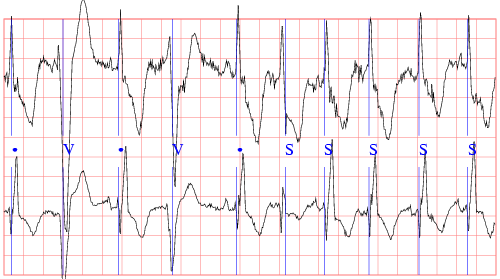

![ECG signal](https://ars.els-cdn.com/content/image/1-s2.0-S0950705120307188-gr1.jpg)

a couple of links:
- [exemplary challenge from Physionet](https://physionet.org/content/challenge-2017/1.0.0/)
- [some recent paper on ECG classification](https://doi.org/10.1016/j.knosys.2020.106589)

## our challenge: classify beats as normal or abnormal (arrhytmia)
- we will utilize signals from **svdb** database, and grab subsequent beats (data preprocessing)
- then construct binary classifier using NN, decision trees, ensemble metchods, and SVM or NaiveBayes

# Dataset preparation
1. Download ecg waves from **svdb** database provided by *PhysioNet*
2. Divide signals into samples, each containing single heartbeat (with window size of 96 points, *sampling ratio* = 128 points/s)
3. Take only samples annotated as 'N' (normal beat), or 'S' and 'V' (arrhythmias)

In [1]:
import os
import numpy as np

# install PhysioNet ecg data package 
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 2.8 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid use and related contexts from MIMIC-III Critical Care Database discharge summaries'],
 ['antimicrobial-resistance-uti',
  'AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['auditory-eeg', 'Auditory evoked potential EEG-Biometric dataset'],
 ['autonomic-aging-cardiovascular',
  'Autonomic Aging: A dataset to quantify ch

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [2]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-48,position+48] window
    beats = np.zeros((len(annotations.sample[5:-5]), time_window*2))
    # note that we remove first and last few beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove first and last few annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...872...file
...processing...804...file
...processing...877...file
...processing...867...file
...processing...881...file
...processing...894...file
...processing...855...file
...processing...805...file
...processing...886...file
...processing...851...file
...processing...820...file
...processing...809...file
...processing...826...file
...processing...840...file
...processing...810...file
...processing...887...file
...processing...885...file
...processing...876...file
...processing...825...file
...processing...841...file
...processing...861...file
...processing...862...file
...processing...849...file
...processing...853...file
...processing...889...file
...processing...883...file
...processing...845...file
...processing...829...file
...processing...859...file
...processing...858...file
...processing...854...file
...processing...852...file
...processing...812...file
...processing...868...file
...processing...875...file
...processing...888...file
...processing...803...file
.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp39-cp39-linux_x86_64.whl size=12062422 sha256=ae9800d7437536ecf9db1ef52d2d60ed52833db1d6ba8a95c44d172cc3c1d468
  Stored in directory: /root/.cache/pip/wheels/88/5f/33/d7b8943eba74fdfbd535c83cefcf366c25b0f9cb6424e763e7
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.1.0 requires matplotlib<4.0.0,>=3.2.2, but you have matplotlib 3.1.3 which is incompatible.
plotnine 0.10.1 requires matpl

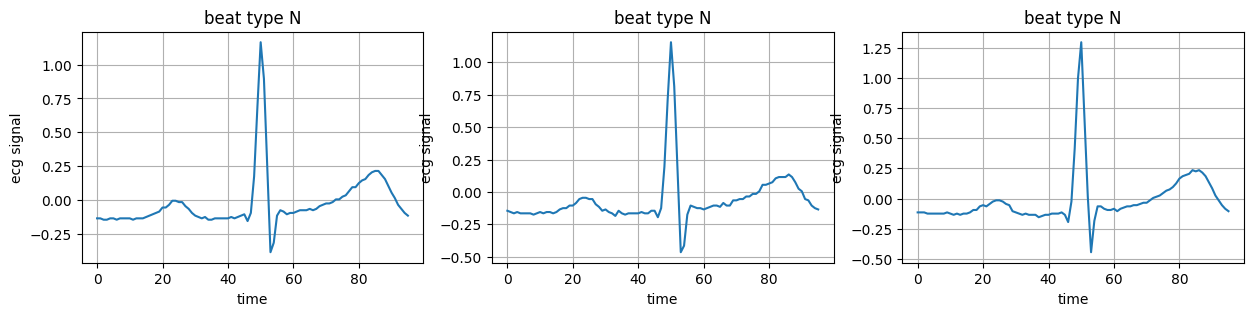

In [3]:
# show example samples
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
print(all_annotations[:100])
sample_number = [0,6,8]
for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

# Experiments

0. Preliminaries
> - Divide dataset into train/validation/test subset, and normalize each of them. 
> - Define classification accuracy metrics (dataset is imbalanced)
>>Confusion matrix
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h | 
```
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$

1. Standard classifiers: *naive Bayes* and *SVM*
2. Decision Tree with optimized max_depth
3. Random Forest with vector of features

In [4]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training 
# we take only some part of the whole dataset
X, y = all_beats[::10], all_annotations[::10]

# train/validation/test set splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')    
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a 

12859 2756 2756


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

svc = SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

svc = SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.8251
Arrhythmia accuracy, Acc_A = 0.3919
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.9383
Arrhythmia accuracy, Acc_A = 0.5303
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.9224
Arrhythmia accuracy, Acc_A = 0.7954
-----------------------------------


Summary of this part:
1. The goal is to maximize both metrics Acc_T and Acc_A at the same time
1. naive Bayes performs rather poorly
> - problem with data imbalace
2. SVM has simillar problem, but after data balacing works quite good

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.8512
Arrhythmia accuracy, Acc_A = 0.7291
-----------------------------------
1 0.1001 0.7562
2 0.1121 0.8466
3 0.8875 0.4493
4 0.8345 0.4822
5 0.8110 0.5945
6 0.7812 0.6466
7 0.8237 0.6247
8 0.8618 0.6466
9 0.8650 0.6438
10 0.8759 0.6466
11 0.7656 0.7178
12 0.7805 0.7288
13 0.7972 0.7205
14 0.7605 0.7315
15 0.8153 0.7178
16 0.8091 0.7205
17 0.8320 0.7233
18 0.8208 0.7178
19 0.8335 0.7068
20 0.8364 0.7096
21 0.8345 0.7096
22 0.8389 0.7123
23 0.8371 0.7068
24 0.8411 0.7068
25 0.8403 0.7123


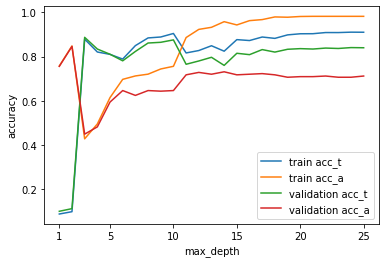

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                                 class_weight='balanced', 
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [ ]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')

# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=14)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

-----------------------------------
DT: Acc_A maximized
Total accuracy, Acc_T = 0.8813
Arrhythmia accuracy, Acc_A = 0.6455
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized
Total accuracy, Acc_T = 0.7587
Arrhythmia accuracy, Acc_A = 0.7579
-----------------------------------


In [ ]:
# feature vector via PCA (dimensionlality reduction) works poorly
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with PCA')

-----------------------------------
DT with PCA
Total accuracy, Acc_T = 0.5439
Arrhythmia accuracy, Acc_A = 0.4092
-----------------------------------


Summary:
1. Decision Tree works a bit worse (than SVM) and has tendency to overfit. We consider two types of hyperparameters:
> - *max_depth*
> - *min_samples_leaf*
2. Tunning *max_depth* gives Acc_A (*max_depth*=8), or Acc_T & Acc_A (*max_depth*=13) maximum value
3. Simple dimensionality reduction using PCA works rather poorly

In [ ]:
import pywt

# extract features using different wavelets and simple differences
def extract_features(input_sample):
    out = np.array([])
# sym8
    cA = pywt.downcoef('a', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cD)
# db6/9
    cA = pywt.downcoef('a', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cD)
    cA = pywt.downcoef('a', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cD)
# dmey
    cA = pywt.downcoef('a', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cD)

# differences
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t+1]-input_sample[t]
    out = np.append(out,differences)
    return out

# collect vector of features for all samples
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data])

X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=15)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', 
                             n_estimators=500, 
                             max_depth=10, 
                             class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

(12859, 64)
(2756, 64)
-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.8545
Arrhythmia accuracy, Acc_A = 0.7435
-----------------------------------
-----------------------------------
RF with wavelets
Total accuracy, Acc_T = 0.9445
Arrhythmia accuracy, Acc_A = 0.6801
-----------------------------------
-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.8984
Arrhythmia accuracy, Acc_A = 0.4755
-----------------------------------


# Tasks to do 
Please choose and complete just **one** of them:
1. Modify classifier to get **accuracy > 0.81** for both Acc_T *and* Acc_A
> - play with classifier hyperparameters
> - add some other features, e.g:
>> - [mean of absolute value (MAV) of signal](https://www.researchgate.net/publication/46147272_Sequential_algorithm_for_life_threatening_cardiac_pathologies_detection_based_on_mean_signal_strength_and_EMD_functions)
>> - some other signal features from [scipy signal](https://docs.scipy.org/doc/scipy/reference/signal.html#peak-finding), 
>> - distances between previous and next heartbeats are strong features, see e.g. [here](https://link.springer.com/article/10.1007/s11760-009-0136-1),
>> - it may be also usefull to perform some feature selection, e.g. choose these with variance higher than some assumed threshold (*intuition*: variance measures amount of information in a given feature), or use *model.feature_importances_* attribute (for more see [here](https://scikit-learn.org/stable/modules/feature_selection.html))
> - balance dataset by yourself: equalize the size of each of 3 groups (hint: take the whole dataset)
> - or build your own classifier using [MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification) 

## 1. Modify classifier to get **accuracy > 0.81** for both Acc_T *and* Acc_A

> ### balance dataset by yourself: equalize the size of each of 3 groups (hint: take the whole dataset)

In [5]:
# print data statistics
print("\n whole")
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))
# print data statistics
print("\n initial")
print(X.shape, y.shape)
print('no of N beats: ' + str(np.count_nonzero(y == 'N')))
print('no of S beats: ' + str(np.count_nonzero(y == 'S')))
print('no of V beats: ' + str(np.count_nonzero(y == 'V')))


 whole
(183707, 96) (183707,)
no of N beats: 161653
no of S beats: 12146
no of V beats: 9908

 initial
(18371, 96) (18371,)
no of N beats: 16227
no of S beats: 1161
no of V beats: 983


| Classifier                 | Arrhythmia accuracy, Acc_A | Total accuracy, Acc_T |
|----------------------------|----------------------------|-----------------------|
| naive Bayes                | 0.3919                     | 0.8251                |
| SVM                        | 0.5303                     | **0.9383**                |
| balanced SVM               | **0.7954**                     | 0.9224                |
| balanced DT                | 0.7291                     | 0.8512                |
| DT: Acc_A maximized        | 0.6455                     | 0.8813                |
| DT: Acc_T + Acc_A maximized | 0.7579                     | 0.7587                |
| DT with PCA                | 0.4092                     | 0.5439                |
| DT with wavelets           | 0.7435                     | 0.8545                |
| RF with wavelets           | 0.6801                     | 0.9445                |
| Ada with wavelets          | 0.4755                     | 0.8984                |


In [6]:
y_balanced = [] 
smallest_size = np.count_nonzero(all_annotations == "V")
a = all_beats[all_annotations == 'V']
print(a.shape)
y_balanced.append(['V']*smallest_size)
b = all_beats[all_annotations == 'S'][0:smallest_size,:]
print(b.shape)
y_balanced.append(['S']*smallest_size)
c = all_beats[all_annotations == 'N'][0:smallest_size,:]
print(c.shape)
y_balanced.append(['N']*smallest_size)


import itertools
y_balanced = list(itertools.chain.from_iterable(y_balanced))
y_balanced = np.array(y_balanced)
X_balanced = np.vstack((a,b,c))
print("\n biggest equal")
print(X_balanced.shape, y_balanced.shape)


(9908, 96)
(9908, 96)
(9908, 96)

 biggest equal
(29724, 96) (29724,)


In [13]:
# train/validation/test set splitting 
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=0)
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.15/0.85, random_state=0)
print(len(y_train_balanced), len(y_val_balanced), len(y_test_balanced))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train_balanced)
X_train_balanced = scaler.transform(X_train_balanced)
# same for the validation subset
X_val_balanced = preprocessing.StandardScaler().fit_transform(X_val_balanced)
# and for the test subset
X_test_balanced = preprocessing.StandardScaler().fit_transform(X_test_balanced)

20806 4459 4459


In [14]:
from sklearn.svm import SVC

svc = SVC()
y_pred_balanced = svc.fit(X_train_balanced, y_train_balanced).predict(X_test_balanced)
calculate_accuracy(y_pred_balanced, y_test_balanced, comment='SVM classifier - balanced dataset')

svc = SVC(class_weight='balanced')
y_pred_balanced = svc.fit(X_train_balanced, y_train_balanced).predict(X_test_balanced)
calculate_accuracy(y_pred_balanced, y_test_balanced, comment='balanced SVM classifier- balanced dataset')

-----------------------------------
SVM classifier - balanced dataset
Total accuracy, Acc_T = 0.8977
Arrhythmia accuracy, Acc_A = 0.8634
-----------------------------------
-----------------------------------
balanced SVM classifier- balanced dataset
Total accuracy, Acc_T = 0.8977
Arrhythmia accuracy, Acc_A = 0.8637
-----------------------------------


cool result, if dataset is balanced there is no difference if we use <code> class_weight='balanced'</code> 



### play with classifier hyperparameters

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.8932
Arrhythmia accuracy, Acc_A = 0.8833
-----------------------------------
1 0.5214 0.3022
2 0.6492 0.4935
3 0.7233 0.6124
4 0.7535 0.6604
5 0.7816 0.7716
6 0.8058 0.8067
7 0.8224 0.7670
8 0.8453 0.7981
9 0.8796 0.8474
10 0.8829 0.8517
11 0.8892 0.8610
12 0.8941 0.8673
13 0.8977 0.8736
14 0.8977 0.8739
15 0.8977 0.8736
16 0.8975 0.8769
17 0.8995 0.8779
18 0.8966 0.8762
19 0.8975 0.8785
20 0.9000 0.8828
21 0.8995 0.8832
22 0.8991 0.8822
23 0.8973 0.8818
24 0.8962 0.8802
25 0.8953 0.8828


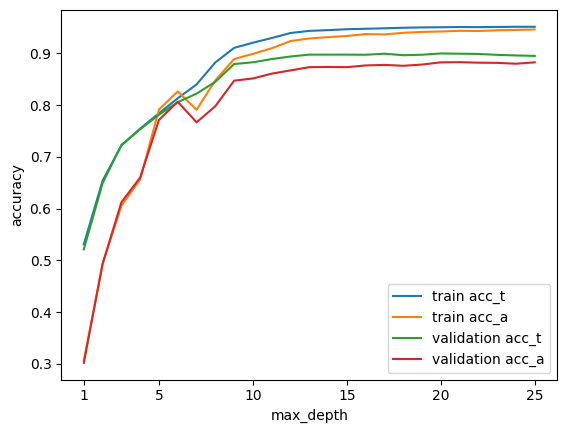

In [32]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10)
y_pred_balanced = dtc.fit(X_train_balanced, y_train_balanced).predict(X_test_balanced)
calculate_accuracy(y_pred_balanced, y_test_balanced, comment='balanced DT')

# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                                 class_weight='balanced', 
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train_balanced, y_train_balanced)
    y_pred_train = dt_fit.predict(X_train_balanced)
    y_pred_val = dt_fit.predict(X_val_balanced)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train_balanced, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val_balanced, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

previously max of acc_t on validation was for 10 and acc_a on validation for 14

now:

In [33]:
max_value = max(val_acc_t)
max_index = val_acc_t.index(max_value)
max_value, max_index

(0.8999775734469612, 19)

but:

In [34]:
val_acc_t[13], val_acc_t[14], val_acc_t[15]

(0.8977349181430814, 0.8977349181430814, 0.8975106526126935)

In [35]:
max_value = max(val_acc_a)
max_index = val_acc_a.index(max_value)
max_value, max_index

(0.8831512744124462, 20)

so lets try 14 and 19

In [39]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=14,
                             max_depth=19)
y_pred_balanced = dtc.fit(X_train_balanced, y_train_balanced).predict(X_test_balanced)
calculate_accuracy(y_pred_balanced, y_test_balanced, comment='DT: 19, balanced')

# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=14)
y_pred_balanced = dtc.fit(X_train_balanced, y_train_balanced).predict(X_test_balanced)
calculate_accuracy(y_pred_balanced, y_test_balanced, comment='DT: Acc_T + Acc_A maximized, balanced')

-----------------------------------
DT: 19, balanced
Total accuracy, Acc_T = 0.8932
Arrhythmia accuracy, Acc_A = 0.8698
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized, balanced
Total accuracy, Acc_T = 0.8989
Arrhythmia accuracy, Acc_A = 0.8705
-----------------------------------


### build your own classifier using MLP